In [39]:
import altair as alt
from pathlib import Path
import json
import pandas as pd
import numpy as np

In [40]:
standard_hls = pd.read_csv("../results/standard/hls/data.csv")
standard_futil = pd.read_csv("../results/standard/futil/data.csv")
standard_futil_lat = pd.read_csv("../results/standard/futil-latency/data.csv")
unrolled_hls = pd.read_csv("../results/unrolled/hls/data.csv")
unrolled_futil = pd.read_csv("../results/unrolled/futil/data.csv")
unrolled_futil_lat = pd.read_csv("../results/unrolled/futil-latency/data.csv")
polybench = standard_hls.append(standard_futil).append(standard_futil_lat).append(unrolled_hls).append(unrolled_futil).append(unrolled_futil_lat).reset_index(drop=True)
polybench

,benchmark,type,key,value
0,gesummv,hls,total_lut,796
1,gesummv,hls,instance_lut,40
2,gesummv,hls,lut,756
3,gesummv,hls,dsp,12
4,gesummv,hls,avg_latency,532
...,...,...,...,...
385,gramschmidt,futil-unrolled,latency,7364
386,doitgen,futil-unrolled,latency,23058
387,syrk,futil-unrolled,latency,5262
388,2mm,futil-unrolled,latency,3999


In [41]:
data = polybench

rename = {
    'avg_latency': 'latency',
}
# keys to keep
include = ['dsp', 'lut', 'latency']

# rename
for k, v in rename.items():
    data.loc[data['key'] == k, 'key'] = v

# only keep things in include
data = data[data['key'].isin(include)].reset_index(drop=True)

data[data['benchmark'] == 'mvt']

,benchmark,type,key,value
48,mvt,hls,lut,657
49,mvt,hls,dsp,6
50,mvt,hls,latency,597
89,mvt,futil,lut,1404
90,mvt,futil,dsp,6
111,mvt,futil,latency,1865
144,mvt,hls-unrolled,lut,1353
145,mvt,hls-unrolled,dsp,24
146,mvt,hls-unrolled,latency,421
167,mvt,futil-unrolled,lut,2298


In [55]:
# Take the norm of all the variables
norm_data = data

def match(df, benchmark, typ):
    return df[(df['benchmark'] == benchmark) & (df['type'] == typ)]

for bench in norm_data['benchmark'].unique():
    norm = match(norm_data, bench, 'futil').copy()
    norm['value'] = match(norm_data, bench, 'futil')['value'].values / match(norm_data, bench, 'hls')['value'].values
    norm['type'] = 'norm'
    
    norm_ur = match(norm_data, bench, 'futil-unrolled').copy()
    norm_ur['value'] = match(norm_data, bench, 'futil-unrolled')['value'].values / match(norm_data, bench, 'hls-unrolled')['value'].values
    norm_ur['type'] = 'norm-unrolled'
    norm_data = norm_data.append(norm).append(norm_ur).reset_index(drop=True)

norm_data
# df.loc['2mm', 'latency-norm'] = df.loc['2mm', 'LATENCY']['futil'] / df.loc['2mm', 'LATENCY']['hls']
# df

,benchmark,type,key,value
0,gesummv,hls,lut,756.000000
1,gesummv,hls,dsp,12.000000
2,gesummv,hls,latency,532.000000
3,syr2k,hls,lut,726.000000
4,syr2k,hls,dsp,9.000000
...,...,...,...,...
265,lu,norm,dsp,2.000000
266,lu,norm,latency,1.457347
267,bicg,norm,lut,0.993884
268,bicg,norm,dsp,1.000000


In [59]:
df = norm_data.pivot(index=['benchmark', 'type'], columns='key', values='value').reset_index()

order = [
    '2mm', 
    '3mm', 
    'atax',
    'doitgen',
    'gemm',
    'gemver',
    'gesummv',
    'gramschmidt',
    'mvt',
    'syr2k', 
    'syrk',
    'bicg',
    'cholesky',
    'durbin',
    'lu',
    'ludcmp',
    'symm',
    'trisolv', 
    'trmm'
]

df['benchmark'] = pd.Categorical(df['benchmark'], order)
df

key,benchmark,type,dsp,latency,lut
0,2mm,futil,12.0,15591.000000,4405.000000
1,2mm,futil-unrolled,84.0,3999.000000,7158.000000
2,2mm,hls,12.0,3718.000000,939.000000
3,2mm,hls-unrolled,72.0,2686.000000,3516.000000
4,2mm,norm,1.0,4.193384,4.691161
...,...,...,...,...,...
85,trisolv,hls,3.0,377.000000,570.000000
86,trisolv,norm,1.0,0.936340,0.543860
87,trmm,futil,6.0,3824.000000,252.000000
88,trmm,hls,6.0,1553.000000,319.000000


# 6a. Cycle counts normalized to Vivado HLS

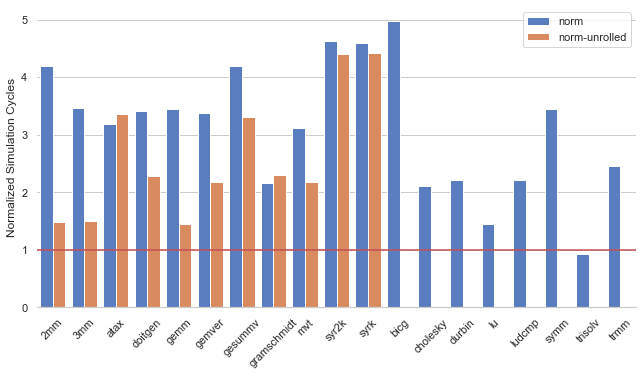

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

g = sns.catplot(
    x="benchmark",
    y="latency",
    hue="type",
    data=df[df['type'].isin(['norm', 'norm-unrolled'])],
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
# g.savefig('log-norm-lat.pdf')

# 6b. LUT usage normalized to Vivado HLS

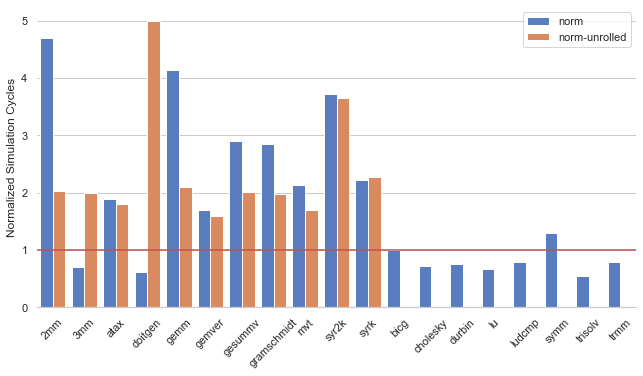

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

g = sns.catplot(
    x="benchmark",
    y="lut",
    hue="type",
    data=df[df['type'].isin(['norm', 'norm-unrolled'])],
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
# g.savefig('log-norm-lat.pdf')

# 6c. Cycle counts normalized to latency-insensitive design 

In [ ]:
# todo: